This is a simple example on how you can use a jupyter notebook to train your model :) 

In [1]:
import torch
import torch.nn as nn
import torchvision
import utils
#from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots

In [2]:
#Dataloader for task 4a)
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import typing
import numpy as np
np.random.seed(0)

mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]


def load_cifar10(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        #transforms.RandomAffine(degrees=15, scale=(0.5,2))
    ])
    transform_test = transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    data_train = datasets.CIFAR10('data/cifar10',
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10('data/cifar10',
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test

In [3]:
class ResnetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 10) # No need to apply softmax,
                                            # as this is done in nn.CrossEntropyLoss

        for param in self.model.parameters(): # Freeze all parameters
            param.requires_grad = False

        for param in self.model.fc.parameters(): # Unfreeze the last fully-connected
            param.requires_grad = True          # layer

        for param in self.model.layer4.parameters(): # Unfreeze the last 5 convolutional
            param.requires_grad = True               # layers

    def forward(self, x):
        x = self.model(x)
        return x


Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/martahal/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResnetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

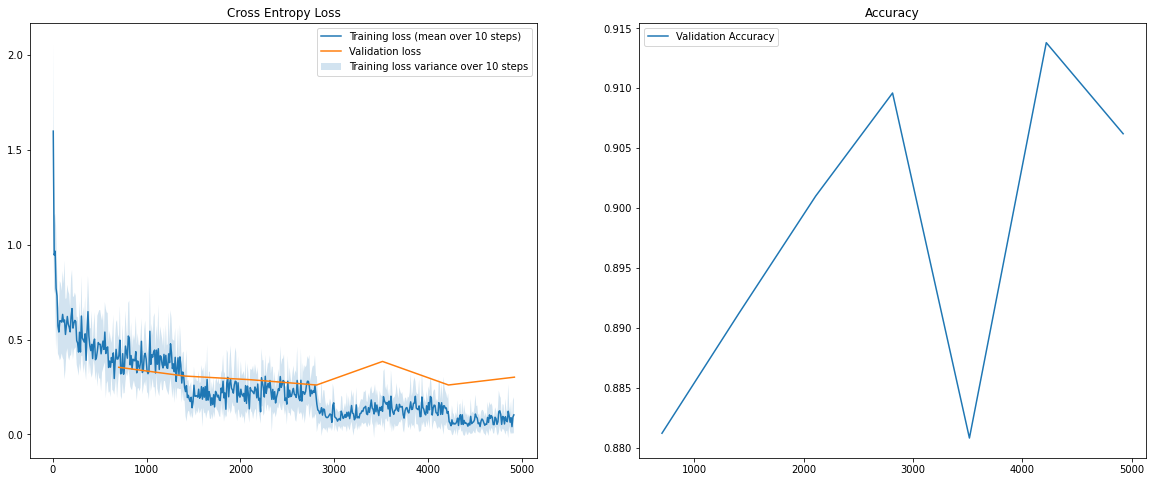

ResnetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [4]:
    # Set the random generator seed (parameters, shuffling etc).
    # You can try to change this and check if you still get the same result! 
    utils.set_seed(0)
    epochs = 10
    batch_size = 32
    learning_rate = 5e-4
    early_stop_count = 4
    dataloaders = load_cifar10(batch_size)
    model = ResnetModel()
    trainer = Trainer(
        batch_size,
        learning_rate,
        early_stop_count,
        epochs,
        model,
        dataloaders
    )
    trainer.train()
    create_plots(trainer, "task4")

    #Loading best model and plotting train, val, test accuracy
    trainer.load_best_model()
    print(trainer.model)
    train_loss, train_acc = compute_loss_and_accuracy(
        dataloaders[0], trainer.model, loss_criterion=nn.CrossEntropyLoss()
    )
    val_loss, val_acc = compute_loss_and_accuracy(
        dataloaders[1], trainer.model, loss_criterion=nn.CrossEntropyLoss()
    )

    test_loss, test_accuracy = compute_loss_and_accuracy(
        dataloaders[2], trainer.model, loss_criterion=nn.CrossEntropyLoss()
    )
    print('Performance for best model:')
    print('train loss, ', train_loss)
    print('train accuracy: ', train_acc)
    print('validation loss: ', val_loss)
    print('validation accuracy: ', val_acc)
    print('test_loss: ', test_loss)
    print('test_accuracy: ', test_accuracy)
